In [ ]:
#Takes DRS batch file (.csv) and returns absolute filepaths (.txt) for Handprint + OCR lookup table (.csv)
##Matt Cook - 2021
import pandas as pd
import os
import sys
from pathlib import Path

#inputs
tableIn = pd.read_csv(("xxx/Nextcloud/Houghton/SAEF/2_ready/afam_fy21_batch0008/HOU-afam_fy21_batch0008_sorted.csv"), usecols=['FILE-OSN']) ##batch info csv
target ="xxx/Nextcloud/Houghton/SAEF/2_ready/afam_fy21_batch0008" #target image directory

#outputs
pathsOut = open("xxx/Nextcloud/Houghton/SAEF/3_inprogress/OCR_Paths.txt", "w") # for Handprint
tableOut = "xxx/Nextcloud/Houghton/SAEF/3_inprogress/OCR_LookupTable.csv"# transcription batch csv

#dataframe
df = pd.DataFrame()

#cross-check that DRS FILE-OSN values exist in target directory and add matches to pathsOut + dataframe
for path in sorted(Path(target).rglob('*.jpg')):
    if path.stem in tableIn.values: #check if image exists in batch info
        absolute = (str(path.parent) + "/" + path.name) #absolute path for images
        pathsOut.write(str(absolute)) #write paths to pathsOut
        pathsOut.write("\n")
        df = df.append({'FILE-OSN':path.stem,'IMG-PATH':absolute}, ignore_index=True) #append data frame  
        print("image " + path.stem + " located " + "at " + absolute) #console out

#create new lookupt table from dataframe
with open(tableOut, mode = 'w') as f:
    df.to_csv(f,index=False) #append tableOut with FILE-OSN and IMG-PATH values

print("\n")
print("lookup table created for collection")
pathsOut.close()


In [ ]:
#Run Handprint using paths from local file
##Mike Hucka designed and implemented Handprint beginning in mid-2018.
##installation instructions at https://github.com/caltechlibrary/handprint

##generate Microsoft results
!handprint --service microsoft -@".../Nextcloud/Houghton/SAEF/saefdvtest/OCR/OCR_log.txt" --from-file ".../Nextcloud/Houghton/SAEF/saefdvtest/OCR/HP_searchPaths.txt" --no-grid --extended --output ".../Nextcloud/Houghton/SAEF/saefdvtest/OCR/MSFT"

In [ ]:
#Takes preliminary lookup table (CSV) and outputs updated table with locations for Handprint outputs, by file type
##Matt Cook - 2021

import pandas as pd
import os
import sys
from pathlib import Path

#Declarations
table = ".../Nextcloud/Houghton/SAEF/saefdvtest/OCR/OCR_LookupTable.csv" ##Lookup table
hpOut =".../Nextcloud/Houghton/SAEF/saefdvtest/OCR/MSFT"##HandPrint Outputs
types = ['MSFT-IMG','MSFT-JSON','MSFT-TXT']##additional lookup table columns
suffX = ['.png','.json','.txt']#OCR file types
num = 0 ##counter
df = [1, 2, 3] #empty dataframes

#match DRS "FILE-OSN" to OCR outputs and append new dataframes 
while num < len(df):  
    df[num] = pd.DataFrame()
    for path in sorted(Path(hpOut).rglob('*' + str(suffX[num]))): #Loop through file types
        #define location and match to DRS's "FILE-OSN" column value
        absolute = (str(path.parent) + "/" + path.name)
        match = path.stem.split('.')
        fileCore = pd.read_csv(table, usecols=['FILE-OSN'])
        #append dataframe with matching values
        for value in fileCore.values:
            if value == match[0]:
                df[num] = df[num].append({types[num]:absolute}, ignore_index=True)
                print("\n")
                print("dataframe " + str(num + 1) + " appended with " + suffX[num] + " located at " + absolute)
    num = num + 1   
    
#concatenate newly appended data frames with existing lookup table
conC = pd.concat(df, axis=1)
print("\n")
print("new dataframes concatenated")
out = pd.concat([pd.read_csv(table),conC], axis=1)

#update lookup table CSV
with open(table, mode = 'w') as f:
    out.to_csv(f,index=False, header=f.tell()==0) #append tableOut with FILE-OSN and IMG-PATH values
    print("\n")
    print("lookup table updated with HandPrint output locations for " + str(types) + "-type transcriptions")
    print("\n")
    print("have a nice day")
        

In [ ]:
####Generates Bag-of-Words txt output from HandPrint transcriptions. 
###MNC - 5/21

import os
import sys
import re
from pathlib import Path

#input/output
paths = 'xxx'#plain text list of urls or filenames (pre-existing)
target = 'xxx' #HP outputs (pre-existing)
textOut = 'xxx'#Bag-of-Words output

#declarations
BoW = open(textOut, "a")

#append bag-of-words with headers and transcriptions
for path in sorted(Path(target).rglob('*.txt')):
    header = path.stem.split('.')
    BoW.write("\n")
    BoW.write(header[0]) #write headers location to bag-of-words
    BoW.write("\n")
    print((header[0]) + " added to bag-of-words")
    absolute = (str(path.parent) + "/" + path.name)
    contents = open(absolute, "r") 
    BoW.write(str(contents.read())) #write transcriptions to bag-of-words
    print(("Transcription for " + header[0]) + " added to bag-of-words")
    BoW.write("\n")
BoW.close()

print("\n")
print("have a nice day")
        

Francii V. Balche
Qerh
Dale Noen
Frecomens Jugs
Francis V. Balche
Wach
Francis 1
Clerk
hel
J. M. W. Serrurlou Esy
Avier
n. y.
V. Balch
Franklin D. Frov
Yeconomy
Tuber
John R. Bartlett
Providence Teht
Heato
Freedman Cunifim


[(Chatham, 1)]


<IPython.core.display.Javascript object>


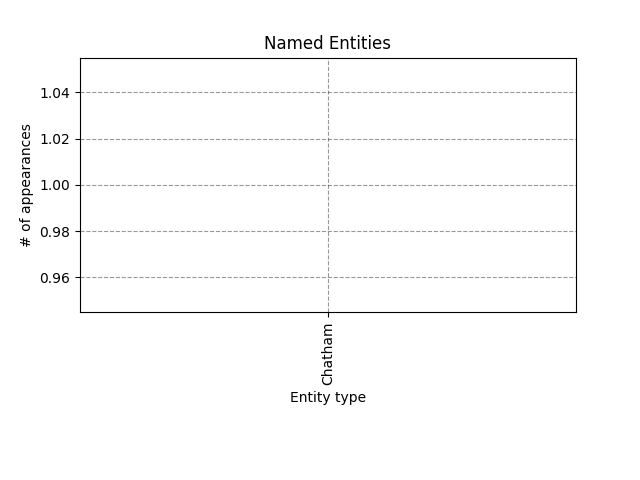

In [7]:
###Named entity recognition and visualization from bag-of-transcriptions
##Modified from "named-entity-recognition" repo by Mary Chester-Kadwell (https://github.com/mchesterkadwell/named-entity-recognition/blob/main/LICENSE)
#Entity types: https://github.com/mchesterkadwell/named-entity-recognition/blob/main/2-named-entity-recognition-of-henslow-data.ipynb
##Matt Cook - November 2021

import click
import spacy
import en_core_web_sm
from spacy import displacy
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter

#declarations
nlp = en_core_web_sm.load()
text_file = Path('data', '/Users/mac6468/Dropbox/DS/Berry/Test 3/bagOfwords.txt')
entOut = open("/Users/mac6468/Dropbox/DS/Berry/Test 3/entities.txt", "w")
    
###named entity recognition
with open(text_file, encoding="utf-8") as file:
    iliad = file.read()
document = nlp(iliad)
document.text
entities = []
for entity in document.ents:
    if entity.label_ == "PERSON": 
        entities.append(entity.text)
        print(entity.text)
entOut.write(str(entities))
displacy.render(document, style="ent")
        
#print high-frenquency entities
word_freq = Counter(entity)
common_words = word_freq.most_common(25)
print(common_words)

#Display the plot in the notebook with interactive controls and save plot to disk
%matplotlib notebook
words = [word for word,_ in common_words]
freqs = [count for _,count in common_words]
plt.title("Named Entities")
plt.xlabel("Entity type")
plt.ylabel("# of appearances")
plt.xticks(range(len(words)), [str(s) for s in words], rotation=90)
plt.grid(b=True, which='major', color='#333333', linestyle='--', alpha=0.5)
plt.gcf().subplots_adjust(bottom=0.35)
plt.plot(freqs)
plt.show()
plt.savefig('/Users/mac6468/Dropbox/DS/Berry/Test 3/graph.png', bbox_inches="tight")

#close files
file.close()
entOut.close()


In [ ]:
#Topic Modeling